# Benchmark: measuring runtime versus # iterations

In [1]:
#imports
import os, time, datetime, json, yaml, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.warnings.filterwarnings('ignore')

#excursion package imports
import excursion
from excursion.estimator import ExcursionSetEstimator

#load testcase
import excursion.testcases.fast_1D as testcase_details

%load_ext autoreload
%autoreload 2

#load algorithm options
file = open('../excursion/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)
print('algorithm_opts =')
print(json.dumps(algorithm_opts, indent=4))


updates = range(10, 40, 1)


algorithm_opts =
{
    "example": "1Dtoyanalysis",
    "ninit": 2,
    "nupdates": 9,
    "init_type": "random",
    "likelihood": {
        "type": "GaussianLikelihood",
        "epsilon": 0.0
    },
    "model": {
        "type": "ExactGP",
        "kernel": "RBF",
        "prior": "Constant"
    },
    "acq": {
        "acq_type": "PES",
        "batch": false,
        "batchtype": "Naive",
        "batchsize": 3
    }
}


In [2]:
means = []
stdev = []
for n in updates:
    runs = []
    for run in range(10):
        device = torch.device('cuda')
        model, likelihood = excursion.init_gp(testcase_details, \
                                    algorithm_opts, \
                                    algorithm_opts["ninit"], \
                                    device)

        # X_init and y_init are random points so that we can fit the GP posterior wrt these points

        # fit hyperparameters
        model.train()
        likelihood.train()
        excursion.fit_hyperparams(model,likelihood)


        # plot the fitting
        # import excursion.plotting.onedim as plots
        # plots.plot_GP(model, testcase_details)


        # this object keeps internal track of the status of all objects involved
        # in excursion at each step
        estimator = ExcursionSetEstimator(testcase_details, \
                                          algorithm_opts, \
                                          model, \
                                          likelihood, \
                                          device)

        start_time = time.process_time()

        n_updates = n
        #save results in folder
        # timestampStr = datetime.datetime.now().strftime('%d-%b-%Y_%H_%M_%S') + '\\'
        # outputfolder = r'C:\Users\excursion\Documents\excursion_project\excursion\examples\results'
        # outputfolder = os.path.join(outputfolder, timestampStr)
        # os.makedirs(outputfolder)

        for iteration in range(n_updates):
            #take a step forward: find new points to evaluate
            estimator.step(testcase_details, algorithm_opts, model, likelihood)


            #plot the new status
            # estimator.plot_status(
            #         testcase_details, algorithm_opts, model, outputfolder)

            #update the posterior of the GP wrt the new points
            model = estimator.update_posterior(testcase_details, algorithm_opts, model, likelihood)

            #get diagnostics (accuracy metric)
            # estimator.get_diagnostics(testcase_details, model, likelihood)
            #
        #save results
        end_time = time.process_time() - start_time

        # estimator.print_results(outputfolder, testcase_details, algorithm_opts)


        runs.append(end_time)

    runs = pd.Series(runs)
    stdev.append(runs.std(ddof=0))
    means.append(runs.mean())

In [3]:
output = pd.DataFrame(data = {'mean': means, 'stdev': stdev}, dtype=float)

timestampStr = datetime.datetime.now().strftime('%d-%b-%Y_%H_%M_%S') + '\\'
outputfolder = r'C:\Users\excursion\Documents\excursion_project\excursion\examples\results'
outputfolder = os.path.join(outputfolder, timestampStr)
os.makedirs(outputfolder)

with open(outputfolder + "rf_gpu_pes.json", "w") as f:
    output.to_json(path_or_buf=f, indent=4)

In [4]:
with open(r'C:\Users\excursion\Documents\excursion_project\no_git\jason_refactor\examples\results\06-Jul-2021_07_24_33\jrf.json', "r") as f:
    jrf = pd.io.json.read_json(path_or_buf=f, typ='frame', dtype=float)

with open(r'C:\Users\excursion\Documents\excursion_project\no_git\irina_developer\examples\results\06-Jul-2021_08_12_28\jrf.json', "r") as f:
    idev = pd.io.json.read_json(path_or_buf=f, typ='frame', dtype=float)

with open(r'C:\Users\excursion\Documents\excursion_project\no_git\lukas_master\examples\results\06-Jul-2021_09_35_17\lm.json', "r") as f:
    lm = pd.io.json.read_json(path_or_buf=f, typ='frame', dtype=float)

with open(r'C:\Users\excursion\Documents\excursion_project\no_git\diana_hep\examples\results\06-Jul-2021_13_52_40\lm.json', "r") as f:
    diana = pd.io.json.read_json(path_or_buf=f, typ='frame', dtype=float)

with open(r'C:\Users\excursion\Documents\excursion_project\excursion\examples\results\09-Jul-2021_22_06_15\jrf.json', "r") as f:
    jrfgpu = pd.io.json.read_json(path_or_buf=f, typ='frame', dtype=float)

with open(r'C:\Users\excursion\Documents\excursion_project\excursion\examples\results\10-Jul-2021_03_03_57\rf_gpu_pes.json', "r") as f:
    jrfgpupes = pd.io.json.read_json(path_or_buf=f, typ='frame', dtype=float)


No handles with labels found to put in legend.


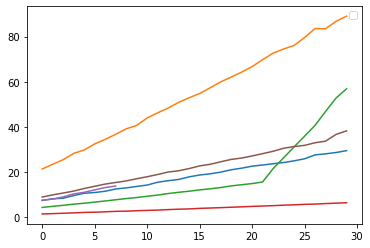

In [5]:
plt.plot(jrf.index.to_list(), jrf['mean_jrf'], )
plt.plot(jrf.index.to_list(), idev['mean_jrf'])
plt.plot(jrf.index.to_list(), lm['mean_lm'])
plt.plot(jrfgpu.index.to_list(), jrfgpu['mean'])
plt.plot(diana.index.to_list(), diana['mean_lm'])
plt.plot(jrfgpupes.index.to_list(), jrfgpupes['mean'])


plt.legend()